In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [51]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib 

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
import pandas as pd
path='/content/drive/My Drive/sih/FinalTrajPred.csv'
df = pd.read_csv(path)
del df['v']
del df['t']

In [53]:
flightId = list(set(df.FlightId))
len(flightId)

2127

In [0]:
 from sklearn.model_selection import train_test_split

In [0]:
trainFlight, testFlight = train_test_split(flightId, test_size=0.6, random_state=42)

In [0]:
# flightSize = int(len(flightId)*0.7)
# trainFlight = flightId[:flightSize]
# testFlight  = flightId[flightSize:]

In [0]:
trainDf = df[df.FlightId.isin(trainFlight)].copy()
trainDf.reset_index(inplace = True,drop=True)
testDf = df[df.FlightId.isin(testFlight)].copy()
testDf.reset_index(inplace = True,drop=True)

In [0]:
trainId = trainDf['FlightId'].copy()
testId = testDf['FlightId'].copy()
del trainDf['FlightId']
del testDf['FlightId']

In [0]:
Cols  = list(trainDf.columns)

In [0]:
scaler = MinMaxScaler(feature_range=(0,1))
trainDf[Cols] = scaler.fit_transform(trainDf[Cols])
testDf[Cols] = scaler.transform(testDf[Cols])

In [61]:
trainDf.head()

,x,y,z
0,0.399771,0.412193,0.000000
1,0.399778,0.440124,0.698339
2,0.399784,0.441412,0.700690
3,0.399791,0.442712,0.703041
4,0.399797,0.444013,0.705290


In [62]:
testDf.head()

,x,y,z
0,0.697006,0.254119,0.707539
1,0.695184,0.254080,0.708050
2,0.693186,0.253958,0.708459
3,0.691095,0.253746,0.708663
4,0.689063,0.253430,0.708612


In [0]:
#Reshape data for RNN/LSTM
def create_dataset(data, k):
    dataX,dataY = [],[]
    for i in range(data.shape[0] -k):
        x = data[i:i+k,:]
        y = data[i+k,:]
        dataX.append(x)
        dataY.append(y)
    return dataX,dataY

In [0]:
trainDf['fid'] = trainId

In [0]:
testDf['fid'] = testId

In [66]:
trainDf

,x,y,z,fid
0,0.399771,0.412193,0.000000,0
1,0.399778,0.440124,0.698339,0
2,0.399784,0.441412,0.700690,0
3,0.399791,0.442712,0.703041,0
4,0.399797,0.444013,0.705290,0
...,...,...,...,...
135265,0.411008,0.451218,0.698799,2382
135266,0.409949,0.449235,0.697879,2382
135267,0.408884,0.447258,0.696908,2382
135268,0.407793,0.445327,0.696090,2382


In [67]:
testDf

,x,y,z,fid
0,0.697006,0.254119,0.707539,2
1,0.695184,0.254080,0.708050,2
2,0.693186,0.253958,0.708459,2
3,0.691095,0.253746,0.708663,2
4,0.689063,0.253430,0.708612,2
...,...,...,...,...
192844,0.943889,0.637506,0.964426,2381
192845,0.950030,0.640745,0.966420,2381
192846,0.956138,0.644074,0.968106,2381
192847,0.962240,0.647467,0.969589,2381


In [0]:
def createDataset(df,look_back):    
    trainX = []
    trainY = []
    fid = list(set(df['fid']))
    # print(fid[:1])
    for flightId in fid:
        tempDf = df[df.fid == flightId].copy()
        del tempDf['fid']
        tempDf.reset_index(drop = True,inplace = True)
        x,y = create_dataset(tempDf.values,look_back)
        trainX.extend(x)
        trainY.extend(y)
    return  trainX,trainY

In [0]:
x,y = createDataset(trainDf,5)
x,y = np.array(x), np.array(y)

In [70]:
x.shape, y.shape

((131020, 5, 3), (131020, 3))

In [0]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from keras import optimizers
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.utils import normalize, to_categorical

In [0]:
adam = optimizers.Adam()
look_back = 5

In [73]:
x.shape, y.shape

((131020, 5, 3), (131020, 3))

In [74]:
model = Sequential()
# model.add(SimpleRNN(12,input_shape = (look_back, 1),activation='relu'))
model.add(SimpleRNN(12,input_shape = (look_back, 3)))
# model.add(Dropout(0.2))
model.add(Dense(12))
model.add(Dense(3))
model.compile(loss='mean_squared_error',optimizer=adam)
model.fit(x,y,epochs = 30 ,batch_size =1000)

Epoch 1/30
131020/131020 [==============================] - 1s 9us/step - loss: 0.0514
Epoch 2/30
131020/131020 [==============================] - 1s 7us/step - loss: 8.9648e-04
Epoch 3/30
131020/131020 [==============================] - 1s 7us/step - loss: 3.0693e-04
Epoch 4/30
131020/131020 [==============================] - 1s 7us/step - loss: 2.0045e-04
Epoch 5/30
131020/131020 [==============================] - 1s 7us/step - loss: 1.6526e-04
Epoch 6/30
131020/131020 [==============================] - 1s 8us/step - loss: 1.4216e-04
Epoch 7/30
131020/131020 [==============================] - 1s 7us/step - loss: 1.2373e-04
Epoch 8/30
131020/131020 [==============================] - 1s 6us/step - loss: 1.0770e-04
Epoch 9/30
131020/131020 [==============================] - 1s 7us/step - loss: 9.4361e-05
Epoch 10/30
131020/131020 [==============================] - 1s 7us/step - loss: 8.2972e-05
Epoch 11/30
131020/131020 [==============================] - 1s 7us/step - loss: 7.2947e-05
E

In [0]:
y_predict = model.predict(x)

In [0]:
from sklearn.metrics import r2_score

In [77]:
y_predict.shape

(131020, 3)

In [78]:
y.shape

(131020, 3)

In [0]:
y_true = scaler.inverse_transform(y)
y_pred = scaler.inverse_transform(y_predict)

In [80]:
r2_score(y_true,y_pred)

0.9987241795164161

In [0]:
x_test,y_test = createDataset(testDf,5)
x_test,y_test = np.array(x_test), np.array(y_test)

In [0]:
y_test_pred = model.predict(x_test)

In [0]:
y_true1 = scaler.inverse_transform(y_test)
y_pred1 = scaler.inverse_transform(y_test_pred)


In [84]:
r2_score(y_true1,y_pred1)

0.9987479993459125

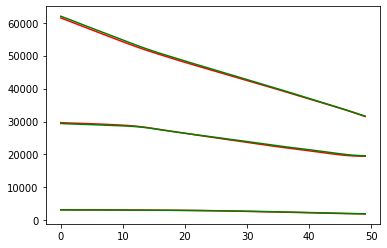

In [85]:
a, b= y_true1[110:160,:],y_pred1[110:160,:]
import matplotlib.pyplot as plt
plt.plot(a,c='r')
plt.plot(b,c='g')
plt.show()

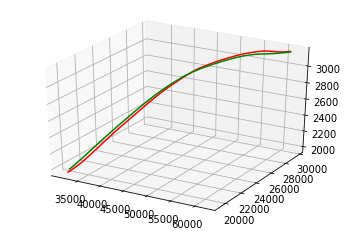

In [86]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax= plt.axes(projection="3d")
ax.plot3D(a[:,0],a[:,1],a[:,2],c='r')
ax.plot3D(b[:,0],b[:,1],b[:,2],c='g')
plt.show()

In [87]:
b . shape

(50, 3)

In [88]:
testDf

,x,y,z,fid
0,0.697006,0.254119,0.707539,2
1,0.695184,0.254080,0.708050,2
2,0.693186,0.253958,0.708459,2
3,0.691095,0.253746,0.708663,2
4,0.689063,0.253430,0.708612,2
...,...,...,...,...
192844,0.943889,0.637506,0.964426,2381
192845,0.950030,0.640745,0.966420,2381
192846,0.956138,0.644074,0.968106,2381
192847,0.962240,0.647467,0.969589,2381


In [91]:
joblib.dump(scaler, '/content/drive/My Drive/sih/scaler_plane.pkl')

['/content/drive/My Drive/sih/scaler_plane.pkl']

In [0]:
from collections import deque
def predictValus(x,look_back,lenPred):
  global model
  pred = []
  pred.extend(list(x))
  x = deque(x)
  assert(len(x) == look_back)
  for i in range(lenPred):
    x_prime = model.predict(np.array(x).reshape((1,look_back,3)))
    x.append(x_prime)
    x.popleft()
    x.append(x_prime)
  return x

In [0]:
architecture = model.to_json()
#saving the jason file in system(on the hard disk)
with open("/content/drive/My Drive/sih/architecture_plane.json", "w") as json_file:
    json_file.write(architecture)
  #now we are saving the trained weights
model.save_weights("/content/drive/My Drive/sih/weights_plane.h5")

In [43]:
!ls

architecture_plane.json  drive	sample_data  weights_plane.h5
